# Zoom / Interpolation Tutorials
This example is taken from the 
[Exercise 7 in the ImgLib2 tutorials](https://github.com/imglib/imglib2-tutorials/blob/master/src/main/java/Example7.java)
A few changes have been made like from ```FloatType``` to ```UnsignedByteType``` so the image can be displayed more easily                                      
                                                                     

In [1]:
load.resolver("imagej.public" at "http://maven.imagej.net/content/groups/public")
load.ivy("net.imagej" % "imagej" % "2.0.0-rc-44") // use % since %% adds scala version
load.ivy("de.christophkraemer" % "rhino-script-engine" % "1.1.0")  // since it's not in the classpath with notebooks per default

:: problems summary ::
:::: WARNINGS
	Unable to reparse com.github.alexarchambault.jupyter#jupyter-scala-api_2.10.5;0.2.0-SNAPSHOT from sonatype-snapshots, using Sun Oct 25 20:00:40 CET 2015

	Unable to reparse com.github.alexarchambault.jupyter#jupyter-scala-api_2.10.5;0.2.0-SNAPSHOT from imagej.public, using Sun Oct 25 20:00:40 CET 2015

	Sorting results from com.github.alexarchambault.jupyter#jupyter-scala-api_2.10.5;0.2.0-SNAPSHOT, using Sun Oct 25 20:00:40 CET 2015 and Sun Oct 25 20:00:40 CET 2015

	Sorting results from com.github.alexarchambault.jupyter#jupyter-scala-api_2.10.5;0.2.0-SNAPSHOT, using Sun Oct 25 20:00:40 CET 2015 and Sun Oct 25 20:00:40 CET 2015

	Choosing imagej.public for com.github.alexarchambault.jupyter#jupyter-scala-api_2.10.5;0.2.0-SNAPSHOT

	Unable to reparse com.github.alexarchambault#ammonite-api_2.10.5;0.3.1-SNAPSHOT from sonatype-snapshots, using Wed Oct 21 11:44:30 CEST 2015

	Unable to reparse com.github.alexarchambault#ammonite-api_2.10.5;0.3.1-SNAPS

```java
/*
 * #%L
 * ImgLib2: a general-purpose, multidimensional image processing library.
 * %%
 * Copyright (C) 2009 - 2015 Tobias Pietzsch, Stephan Preibisch, Barry DeZonia,
 * Stephan Saalfeld, Curtis Rueden, Albert Cardona, Christian Dietz, Jean-Yves
 * Tinevez, Johannes Schindelin, Jonathan Hale, Lee Kamentsky, Larry Lindsey, Mark
 * Hiner, Michael Zinsmaier, Martin Horn, Grant Harris, Aivar Grislis, John
 * Bogovic, Steffen Jaensch, Stefan Helfrich, Jan Funke, Nick Perry, Mark Longair,
 * Melissa Linkert and Dimiter Prodanov.
 * %%
 * Redistribution and use in source and binary forms, with or without
 * modification, are permitted provided that the following conditions are met:
 * 
 * 1. Redistributions of source code must retain the above copyright notice,
 *    this list of conditions and the following disclaimer.
 * 2. Redistributions in binary form must reproduce the above copyright notice,
 *    this list of conditions and the following disclaimer in the documentation
 *    and/or other materials provided with the distribution.
 * 
 * THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
 * AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
 * IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
 * ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDERS OR CONTRIBUTORS BE
 * LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
 * CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
 * SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
 * INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
 * CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
 * ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
 * POSSIBILITY OF SUCH DAMAGE.
 * #L%
 */
```



In [2]:
// make previewing a bit easier
implicit class previewDataset(curSet: net.imagej.Dataset)(implicit ij: net.imagej.ImageJ) {
    /** saves the file to a temporary directory, read it in again as a bytearray and feed it to the jupyter function **/
    def preview() = {
        val tFile = java.io.File.createTempFile("jupy",".jpg")
        ij.scifio().datasetIO().save(curSet,tFile.getPath())
        val imgFIS = new java.io.FileInputStream(tFile.getPath())
        val out = new Array[Byte](imgFIS.getChannel().size().toInt)
        imgFIS.read(out)
        display.jpg(out)
    }
}

defined class previewDataset

# Begin
__Goal__ : Use three different interpolators to 10x magnify a small area

The first section is all of the imports needed


In [3]:
import ij.ImageJ;
import io.scif.img.ImgIOException;
import io.scif.img.ImgOpener;
import net.imglib2.Cursor;
import net.imglib2.FinalRealInterval;
import net.imglib2.RealInterval;
import net.imglib2.RealRandomAccess;
import net.imglib2.RealRandomAccessible;
import net.imglib2.img.Img;
import net.imglib2.img.ImgFactory;
import net.imglib2.img.array.ArrayImgFactory;
import net.imglib2.img.display.imagej.ImageJFunctions;
import net.imglib2.interpolation.randomaccess.LanczosInterpolatorFactory;
import net.imglib2.interpolation.randomaccess.NLinearInterpolatorFactory;
import net.imglib2.interpolation.randomaccess.NearestNeighborInterpolatorFactory;
import net.imglib2.`type`.Type;
import net.imglib2.`type`.numeric.real.FloatType;
import net.imglib2.util.Util;
import net.imglib2.view.Views;

import ij.ImageJ
import io.scif.img.ImgIOException
import io.scif.img.ImgOpener
import net.imglib2.Cursor
import net.imglib2.FinalRealInterval
import net.imglib2.RealInterval
import net.imglib2.RealRandomAccess
import net.imglib2.RealRandomAccessible
import net.imglib2.img.Img
import net.imglib2.img.ImgFactory
import net.imglib2.img.array.ArrayImgFactory
import net.imglib2.img.display.imagej.ImageJFunctions
import net.imglib2.interpolation.randomaccess.LanczosInterpolatorFactory
import net.imglib2.interpolation.randomaccess.NLinearInterpolatorFactory
import net.imglib2.interpolation.randomaccess.NearestNeighborInterpolatorFactory
import net.imglib2.`type`.Type
import net.imglib2.`type`.numeric.real.FloatType
import net.imglib2.util.Util
import net.imglib2.view.Views

In [4]:
/**
 * Compute a magnified version of a given real interval
 *
 * @param source - the input data
 * @param interval - the real interval on the source that should be magnified
 * @param factory - the image factory for the output image
 * @param magnification - the ratio of magnification
 * @return - an Img that contains the magnified image content
 */
def magnify[T <: Type[T]](source: RealRandomAccessible[T],
    interval: RealInterval, factory: ImgFactory[T], magnification: Double ): Img[T] = 
{
    val numDimensions = interval.numDimensions()

    // compute the number of pixels of the output and the size of the real interval
    val pixelSize = new Array[Long](numDimensions)
    val intervalSize = new Array[Double](numDimensions)

    for(d <- 0 until numDimensions) {
        intervalSize(d) = interval.realMax( d ) - interval.realMin( d )
        pixelSize(d) = Math.round( intervalSize(d) * magnification ) + 1
    }

    // create the output image
    val output = factory.create( pixelSize, source.realRandomAccess().get() );

    // cursor to iterate over all pixels
    val cursor = output.localizingCursor();

    // create a RealRandomAccess on the source (interpolator)
    val realRandomAccess = source.realRandomAccess();

    // the temporary array to compute the position
    val tmp = new Array[Double](numDimensions)

    // for all pixels of the output image
    while ( cursor.hasNext() )
    {
        cursor.fwd();

        // compute the appropriate location of the interpolator
        for(d <- 0 until numDimensions) {
            tmp(d) = cursor.getDoublePosition( d ) / output.realMax( d ) * intervalSize( d )
                    + interval.realMin( d );
        }

        // set the position
        realRandomAccess.setPosition( tmp );

        // set the new value
        cursor.get().set( realRandomAccess.get() );
    }

    output
}



defined function magnify

In [5]:
implicit val ij = new net.imagej.ImageJ()

ij: net.imagej.ImageJ = net.imagej.ImageJ@337966c

In [6]:
// open with ImgOpener using an ArrayImgFactory
import net.imglib2.`type`.numeric.integer.UnsignedByteType
val inputImg = "sample-data/starstack.tif"
val typedImage = ij.scifio().datasetIO().open(inputImg).typedImg(new UnsignedByteType())

[INFO] Reading IFDs
[INFO] Populating metadata
[INFO] Checking comment style
[WARNING] Expected positive value for PhysicalSizeX; got 0.0
[WARNING] Expected positive value for PhysicalSizeY; got 0.0
[WARNING] Expected positive value for PhysicalSizeX; got 0.0
[WARNING] Expected positive value for PhysicalSizeY; got 0.0


import net.imglib2.`type`.numeric.integer.UnsignedByteType
inputImg: java.lang.String = "sample-data/starstack.tif"
typedImage: net.imagej.ImgPlus[net.imglib2.type.numeric.integer.UnsignedByteType] = io.scif.img.SCIFIOImgPlus@4df56e63

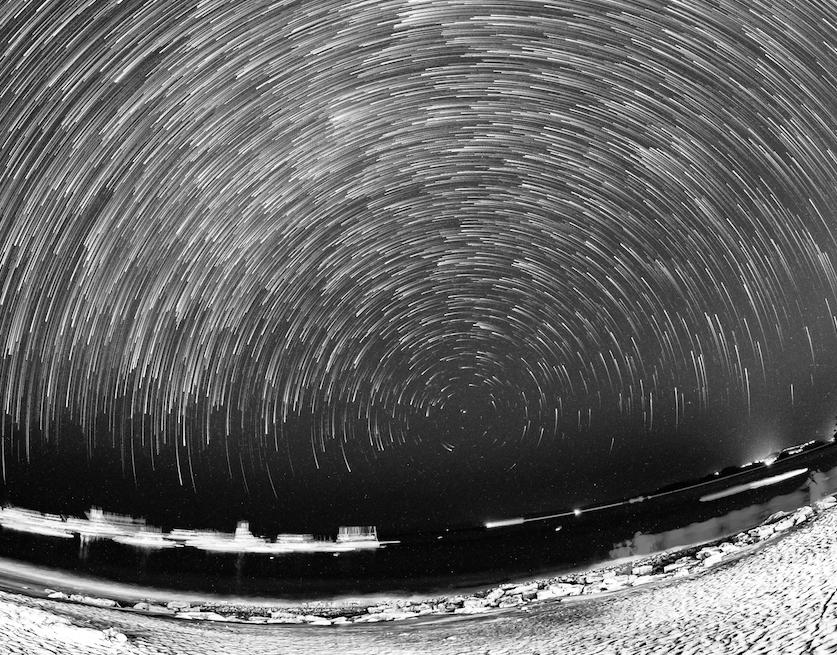

In [7]:
ij.dataset().create(typedImage).preview()

In [8]:
// create an InterpolatorFactory RealRandomAccessible using nearst neighbor interpolation
val factory1 = new NearestNeighborInterpolatorFactory[UnsignedByteType]()
// create an InterpolatorFactory RealRandomAccessible using linear interpolation
val factory2 = new NLinearInterpolatorFactory[UnsignedByteType]()
// create an InterpolatorFactory RealRandomAccessible using lanczos interpolation
val factory3 = new LanczosInterpolatorFactory[UnsignedByteType]()

factory1: net.imglib2.interpolation.randomaccess.NearestNeighborInterpolatorFactory[net.imglib2.type.numeric.integer.UnsignedByteType] = net.imglib2.interpolation.randomaccess.NearestNeighborInterpolatorFactory@4f962da4
factory2: net.imglib2.interpolation.randomaccess.NLinearInterpolatorFactory[net.imglib2.type.numeric.integer.UnsignedByteType] = net.imglib2.interpolation.randomaccess.NLinearInterpolatorFactory@60fe33b3
factory3: net.imglib2.interpolation.randomaccess.LanczosInterpolatorFactory[net.imglib2.type.numeric.integer.UnsignedByteType] = net.imglib2.interpolation.randomaccess.LanczosInterpolatorFactory@6cb81971

In [9]:
// create a RandomAccessible using the factory and views method
// it is important to extend the image first, the interpolation scheme might
// grep pixels outside of the boundaries even when locations inside are queried
// as they integrate pixel information in a local neighborhood - the size of
// this neighborhood depends on which interpolator is used
val interpolant1 = Views.interpolate(
    Views.extendMirrorSingle[UnsignedByteType,Img[UnsignedByteType]]( typedImage ), factory1 );
val interpolant2 = Views.interpolate(
    Views.extendMirrorSingle[UnsignedByteType,Img[UnsignedByteType]]( typedImage ), factory2 );
val interpolant3 = Views.interpolate(
    Views.extendMirrorSingle[UnsignedByteType,Img[UnsignedByteType]]( typedImage ), factory3 );

interpolant1: net.imglib2.RealRandomAccessible[net.imglib2.type.numeric.integer.UnsignedByteType] = net.imglib2.interpolation.Interpolant@672bfb55
interpolant2: net.imglib2.RealRandomAccessible[net.imglib2.type.numeric.integer.UnsignedByteType] = net.imglib2.interpolation.Interpolant@9ab5754
interpolant3: net.imglib2.RealRandomAccessible[net.imglib2.type.numeric.integer.UnsignedByteType] = net.imglib2.interpolation.Interpolant@511f94de

In [10]:
// define the area in the interpolated image
val min =  Array(105.12, 40.43);
val max =  Array(129.56, 74.933);

val interval = new FinalRealInterval( min, max );

min: scala.Array[Double] = Array(105.12, 40.43)
max: scala.Array[Double] = Array(129.56, 74.933)
interval: net.imglib2.FinalRealInterval = net.imglib2.FinalRealInterval@4ef7b45

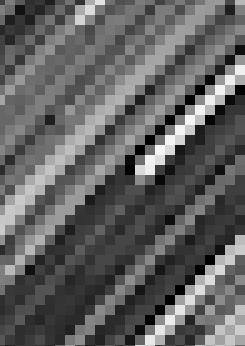

nnImage: net.imglib2.img.Img[net.imglib2.type.numeric.integer.UnsignedByteType] = ArrayImg [245x346]

In [11]:
val nnImage = magnify( interpolant1, interval,
			new ArrayImgFactory[UnsignedByteType](), 10 )
ij.dataset().create(nnImage).preview()

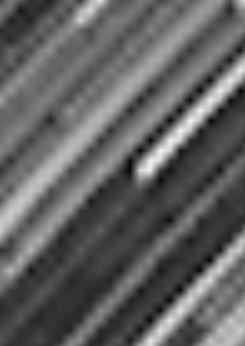

nlImage: net.imglib2.img.Img[net.imglib2.type.numeric.integer.UnsignedByteType] = ArrayImg [245x346]

In [12]:
val nlImage = magnify( interpolant2, interval,
			new ArrayImgFactory[UnsignedByteType](), 10 )
ij.dataset().create(nlImage).preview()

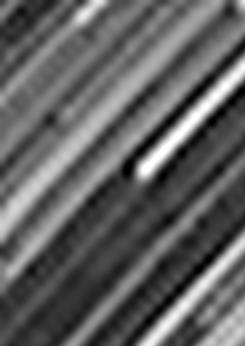

lzImage: net.imglib2.img.Img[net.imglib2.type.numeric.integer.UnsignedByteType] = ArrayImg [245x346]

In [13]:
val lzImage = magnify( interpolant3, interval,
			new ArrayImgFactory[UnsignedByteType](), 10 )
ij.dataset().create(lzImage).preview()